<a href="https://colab.research.google.com/github/MLCoursesBBK/ZiZ_2026/blob/main/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import zscore
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split


### Dataset Description: Fraud Ecommerce

This notebook utilizes the **Fraud Ecommerce** dataset, sourced from **Kagglehub** ([vbinh002/fraud-ecommerce](https://www.kaggle.com/datasets/vbinh002/fraud-ecommerce)). This dataset is designed for fraud detection tasks in an e-commerce context.

It primarily consists of two CSV files:

1.  **`Fraud_Data.csv`**: This file contains transactional data, including details such as user ID, signup time, purchase time, purchase value, device ID, source, browser, sex, age, IP address, and a `class` label indicating whether the transaction is fraudulent (1) or legitimate (0).

2.  **`IpAddress_to_Country.csv`**: This supplementary file provides a mapping from IP address ranges to their corresponding countries. It includes lower and upper bound IP addresses and the country name, which can be used to enrich the transactional data with geographical information.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vbinh002/fraud-ecommerce")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fraud-ecommerce' dataset.
Path to dataset files: /kaggle/input/fraud-ecommerce


In [3]:
dataset = pd.read_csv(os.path.join(path, 'Fraud_Data.csv'))
ip_table = pd.read_csv(os.path.join(path, 'IpAddress_to_Country.csv'))

### Data Preprocessing Steps

Before proceeding with further analysis and model building, we will perform the following preprocessing steps on the `df_combined` DataFrame:

1.  **Feature Engineering**: Extract additional time-based features from `purchase_time` such as month and day of the week to capture potential seasonality.
2.  **Data Type Conversion**: Ensure all relevant columns have appropriate data types for analysis (e.g., converting IP addresses to a numerical format for comparison).
3.  **Missing Value Handling**: Address any missing values, particularly in the `country` column, by either imputation or a dedicated 'Unknown' category.
4.  **Merge IP to Country Data**: Combine the `df_fraud` (transactional data) with `df_ip` (IP address to country mapping) to enrich transactions with geographical information.

In [4]:
# Make copies to avoid modifying original dataframes if they are used elsewhere
df_fraud = dataset.copy()
df_ip = ip_table.copy()

# Convert IP addresses to numeric type for comparison
df_fraud['ip_address'] = df_fraud['ip_address'].astype(np.int64)
df_ip['lower_bound_ip_address'] = df_ip['lower_bound_ip_address'].astype(np.int64)
df_ip['upper_bound_ip_address'] = df_ip['upper_bound_ip_address'].astype(np.int64)

# Sort both dataframes on their respective IP columns for merge_asof
df_fraud_sorted = df_fraud.sort_values('ip_address')
df_ip_sorted = df_ip.sort_values('lower_bound_ip_address')

# Perform merge_asof to find the country for each IP address
# 'direction="backward"' matches the largest 'lower_bound_ip_address' less than or equal to 'ip_address'.
merged_df = pd.merge_asof(
    df_fraud_sorted,
    df_ip_sorted[['lower_bound_ip_address', 'upper_bound_ip_address', 'country']],
    left_on='ip_address',
    right_on='lower_bound_ip_address',
    direction='backward'
)

# Filter out rows where the ip_address does not fall within the upper_bound of the matched range.
# If an IP address is outside the range (i.e., greater than the upper bound), set the country to NaN.
merged_df.loc[
    merged_df['ip_address'] > merged_df['upper_bound_ip_address'],
    'country'
] = np.nan

# Drop the temporary lower_bound_ip_address and upper_bound_ip_address columns from the merged dataframe
df_combined = merged_df.drop(columns=['lower_bound_ip_address', 'upper_bound_ip_address'])

# Ensure 'purchase_time' is in datetime format
df_combined['purchase_time'] = pd.to_datetime(df_combined['purchase_time'])

# Extract month of purchase
df_combined['month_purchase'] = df_combined['purchase_time'].dt.month

# Extract weekday of purchase (Monday=0, Sunday=6)
df_combined['weekday_purchase'] = df_combined['purchase_time'].dt.weekday

print("Combined DataFrame shape:", df_combined.shape)
print("\nFirst 5 rows of the combined DataFrame:")
display(df_combined.head())

Combined DataFrame shape: (151112, 14)

First 5 rows of the combined DataFrame:


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,month_purchase,weekday_purchase
0,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,52093,0,NaN,3,6
1,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,33,YFGYOALADBHLT,Ads,IE,F,30,93447,0,NaN,3,4
2,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,33,QZNVQTUITFTHH,Direct,FireFox,F,32,105818,0,NaN,5,1
3,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,33,PIBUQMBIELMMG,Ads,IE,M,40,117566,0,NaN,5,3
4,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,55,WFIIFCPIOGMHT,Ads,Safari,M,38,131423,0,NaN,4,6


In [6]:

# Also show the actual fraud rate for comparison in df_eval
actual_fraud_rate = df_combined['class'].mean()
print(f"Actual fraud rate in df_eval: {actual_fraud_rate:.4f}")

Actual fraud rate in df_eval: 0.0936


### Semi-supervised Data Splitting for Anomaly Detection

For the Isolation Forest model, we've adopted a semi-supervised approach to data splitting, which is common in anomaly detection tasks where labeled anomalous data might be scarce or used primarily for evaluation.

1.  **Training Data (`df_train`)**: This set consists of **50% of the normal (non-fraudulent) transactions** from the `df_combined` DataFrame. The Isolation Forest model will be trained exclusively on this subset, allowing it to learn the patterns of 'normal' behavior without exposure to anomalies.

2.  **Evaluation Data (`df_eval`)**: This set is created by combining the **remaining 50% of the normal transactions** with **all fraudulent transactions** from `df_combined`. This setup provides a comprehensive dataset to evaluate the model's ability to distinguish between normal and anomalous behavior, as it contains both known normal and known anomalous instances.

In [7]:
# Separate normal and fraudulent data
df_normal_data = df_combined[df_combined['class'] == 0]
df_fraud_data = df_combined[df_combined['class'] == 1]

# Split normal data into two halves for semi-supervised training
# df_train will contain 50% of normal data
# df_normal_rest will contain the other 50% of normal data
df_train, df_normal_rest = train_test_split(
    df_normal_data,
    test_size=0.5, # 50% for evaluation, 50% for training
    random_state=42
)

# df_eval will contain the remaining 50% of normal data + all fraudulent data
df_eval = pd.concat([df_normal_rest, df_fraud_data])

print(f"Shape of df_train (50% normal data): {df_train.shape}")
print(f"Shape of df_eval (50% normal data + all fraud data): {df_eval.shape}")
print(f"Actual fraud rate in df_eval: {df_eval['class'].mean():.4f}")

Shape of df_train (50% normal data): (68480, 14)
Shape of df_eval (50% normal data + all fraud data): (82632, 14)
Actual fraud rate in df_eval: 0.1713


### Model 1: Anomaly Detection using Z-score Method

We'll use the Z-score method to identify anomalies in numerical features. The Z-score measures how many standard deviations an observation is from the mean. Observations with a Z-score above a certain threshold are considered anomalies.

For this example, we'll focus on `purchase_value` and `age` as numerical features for anomaly detection. We'll also use the `class` column from the original dataset as the ground truth for evaluating our model (where `class = 1` indicates fraud/anomaly).

In [8]:

# Select numerical features for Z-score calculation
features = ['purchase_value', 'age']

# Calculate mean and standard deviation from the training data (df_train)
for feature in features:
    mean_train = df_train[feature].mean()
    std_train = df_train[feature].std()

    # Apply Z-score to df_train using train statistics
    df_train[f'zscore_{feature}'] = np.abs((df_train[feature] - mean_train) / std_train)

    # Apply Z-score to df_eval using train statistics
    df_eval[f'zscore_{feature}'] = np.abs((df_eval[feature] - mean_train) / std_train)

# Define a Z-score threshold for anomaly detection
z_score_threshold = 3

# Identify anomalies in df_train
df_train['is_anomaly_zscore'] = (
    (df_train['zscore_purchase_value'] > z_score_threshold) |
    (df_train['zscore_age'] > z_score_threshold)
).astype(int)

# Identify anomalies in df_eval
df_eval['is_anomaly_zscore'] = (
    (df_eval['zscore_purchase_value'] > z_score_threshold) |
    (df_eval['zscore_age'] > z_score_threshold)
).astype(int)

print(f"Number of detected anomalies in df_eval using Z-score (threshold={z_score_threshold}): {df_eval['is_anomaly_zscore'].sum()}")

Number of detected anomalies in df_eval using Z-score (threshold=3): 679


### Evaluate the Anomaly Detection Model 1

Now, let's compute the F1 score and the fraction of detected anomalies based on our Z-score model. The F1 score is a measure of a model's accuracy, considering both precision and recall, and is particularly useful for imbalanced datasets like fraud detection.

In [11]:
# Initialize a dictionary to store model performance metrics
model_performance = {}

# Get true labels (actual fraud cases) from df_eval
y_true = df_eval['class']

# Get predicted labels (anomalies detected by Z-score) from df_eval
y_pred = df_eval['is_anomaly_zscore']

# Compute F1 Score, precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

model_performance['Z-score'] = {
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    # 'PR-AUC': pr_auc
}


Precision: 0.1429
Recall: 0.0069
F1 Score: 0.0131


### Summary of Z-score Anomaly Detection

The Z-score method has been applied, and we've calculated the F1 score and the fraction of detected anomalies. These metrics help us understand how well the Z-score method performs in identifying fraudulent transactions based on `purchase_value` and `age`.

### Model 2: Anomaly Detection using Isolation Forest

Isolation Forest is an ensemble learning method based on decision trees. It works by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. This partitioning is repeated recursively until all instances are isolated. Anomalies are those instances that require fewer random partitions to be isolated. This method is highly effective for detecting outliers in high-dimensional datasets.

We will use `purchase_value` and `age` as numerical features and `source`, `browser`, `sex`, and `country` as categorical features.

In [14]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define numerical and categorical features
numerical_features = ['purchase_value', 'age']
categorical_features = ['source', 'browser', 'sex', 'country', 'month_purchase', 'weekday_purchase']

# Handle missing values in 'country' by filling with 'Unknown'
# df_combined['country'] = df_combined['country'].fillna('Unknown')

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


#
isolation_forest_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('isolationforest', IsolationForest(random_state=42, contamination=0.1))
])

# Train the model
isolation_forest_model.fit(df_train[[*categorical_features, *numerical_features]])

# Get anomaly predictions (-1 for anomalies, 1 for normal)
# Convert -1 to 1 (anomaly) and 1 to 0 (normal) to match our 'class' column (0=normal, 1=fraud)
is_anomaly_iforest = isolation_forest_model.predict(df_eval)
df_eval['is_anomaly_iforest'] = np.where(is_anomaly_iforest == -1, 1, 0)
y_score_iforest = isolation_forest_model.decision_function(df_eval[[*categorical_features, *numerical_features]])

print(f"Number of detected anomalies using Isolation Forest: {df_eval['is_anomaly_iforest'].sum()}")

Number of detected anomalies using Isolation Forest: 9020


### Evaluate the Isolation Forest Anomaly Detection Model

Now, let's compute the F1 score and the fraction of detected anomalies for the Isolation Forest model.

In [17]:

# Get true labels (actual fraud cases)
y_true = df_eval['class']

# Get predicted labels (anomalies detected by Z-score)
y_pred = df_eval['is_anomaly_iforest']

# Compute F1 Score, precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

model_performance['Isolation Forest'] = {
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    # 'PR-AUC': pr_auc
}

Precision: 0.2188
Recall: 0.1395
F1 Score: 0.1704


### Summary of Isolation Forest Anomaly Detection

The Isolation Forest method has been applied using selected numerical and categorical features, and we've calculated the F1 score, precision, recall, and the fraction of detected anomalies. These metrics help us understand how well the Isolation Forest model performs in identifying fraudulent transactions compared to the Z-score method.

### Model 3: Autoencoder Neural Network

In [18]:

# 6. Apply the preprocessor to transform the selected numerical and categorical features
X_train_preprocessed = preprocessor.fit_transform(df_train[numerical_features + categorical_features])

print("Shape of preprocessed training data for Autoencoder:", X_train_preprocessed.shape)
print("First 5 rows of preprocessed training data (sparse matrix might show indices):")
# Since X_train_preprocessed can be a sparse matrix, convert to array for display if it is.
if hasattr(X_train_preprocessed, 'toarray'):
    display(pd.DataFrame(X_train_preprocessed.toarray()).head())
else:
    display(pd.DataFrame(X_train_preprocessed).head())

Shape of preprocessed training data for Autoencoder: (68480, 195)
First 5 rows of preprocessed training data (sparse matrix might show indices):


,0,1,2,3,4,5,6,7,8,9,...,185,186,187,188,189,190,191,192,193,194
0,-0.378115,-0.591295,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.635917,1.379063,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.249048,1.379063,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.813581,-1.634427,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.976881,1.147256,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define the input dimension for the Autoencoder
input_dim = X_train_preprocessed.shape[1]

# Define the Autoencoder architecture
# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(128, activation='relu')(input_layer)
encoder = Dense(64, activation='relu')(encoder)

# Latent space (bottleneck)
latent_space = Dense(32, activation='relu')(encoder)

# Decoder
decoder = Dense(64, activation='relu')(latent_space)
decoder = Dense(128, activation='relu')(decoder)
output_layer = Dense(input_dim, activation='linear')(decoder) # Output activation should match input data scale

# Create the Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compile the Autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
print("Autoencoder Model Summary:")
autoencoder.summary()

# Train the Autoencoder
# We train on the preprocessed normal data (X_train_preprocessed)
# The target output is the input itself (autoencoder's goal is to reconstruct its input)
# Convert X_train_preprocessed to a dense array if it's sparse
X_train_dense = X_train_preprocessed.toarray() if hasattr(X_train_preprocessed, 'toarray') else X_train_preprocessed

history = autoencoder.fit(X_train_dense,
                          X_train_dense,
                          epochs=20,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.2,
                          verbose=1)

print("Autoencoder training complete.")

Autoencoder Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 195)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 195)            │        25,155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,011 (277.39 KB)

 Trainable params: 71,011 (277.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0241 - val_loss: 0.0063
Epoch 2/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0054 - val_loss: 0.0039
Epoch 3/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 4/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 5/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 6/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 7/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 9/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 10/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 11/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 12/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/st

**Evaluation**:
Now we need to calculate anomaly scores using the trained Autoencoder. This involves preprocessing the entire dataset (both normal and fraudulent) using the previously defined `preprocessor_ae`, then using the trained `autoencoder` to reconstruct the data, and finally calculating the reconstruction error (Mean Squared Error) which will serve as the anomaly score. This process is necessary to obtain anomaly scores for all transactions before setting a threshold and evaluating the model.



In [20]:
# Preprocess the entire df_combined DataFrame using the fitted preprocessor
# This includes both normal and fraudulent transactions for anomaly scoring
X_all_preprocessed = preprocessor.transform(df_eval[numerical_features + categorical_features])

# Convert X_all_preprocessed to a dense array if it's sparse
# X_all_dense = X_all_preprocessed.toarray() if hasattr(X_all_preprocessed, 'toarray') else X_all_preprocessed

# Get the reconstructions from the Autoencoder for all data
reconstructions = autoencoder.predict(X_all_preprocessed)

# Calculate the reconstruction error (e.g., Mean Squared Error) for each data point
# We'll calculate the MSE for each row individually
anomaly_scores_ae = np.mean(np.square(X_all_preprocessed - reconstructions), axis=1)

# Add the anomaly scores to the df_combined DataFrame
df_eval['anomaly_score_ae'] = anomaly_scores_ae

print("Anomaly scores calculated and added to df_combined.")

2583/2583 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Anomaly scores calculated and added to df_combined.


**Visualization of anomaly scores**:
To effectively distinguish anomalies, it's beneficial to visualize the distribution of anomaly scores for both normal (class 0) and fraudulent (class 1) transactions. This will help in setting an appropriate threshold that balances precision and recall.



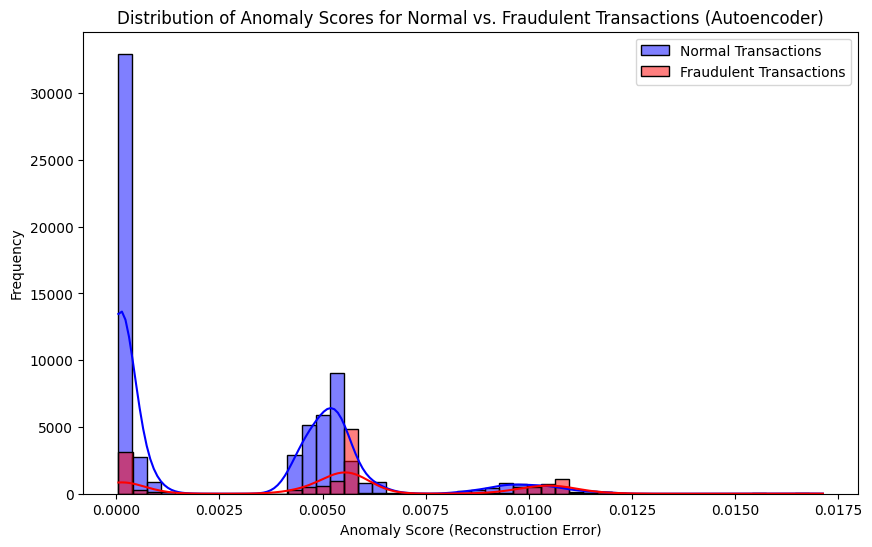

In [21]:
# Visualize the distribution of anomaly scores for normal and fraudulent transactions
plt.figure(figsize=(10, 6))
sns.histplot(df_eval[df_eval['class'] == 0]['anomaly_score_ae'], bins=50, color='blue', label='Normal Transactions', kde=True)
sns.histplot(df_eval[df_eval['class'] == 1]['anomaly_score_ae'], bins=50, color='red', label='Fraudulent Transactions', kde=True)
plt.title('Distribution of Anomaly Scores for Normal vs. Fraudulent Transactions (Autoencoder)')
plt.xlabel('Anomaly Score (Reconstruction Error)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Threshold**:
Based on the visualization of anomaly scores, the next step is to set an anomaly threshold, classify transactions as anomalous based on this threshold, and then evaluate the Autoencoder model's performance using F1 score, precision, recall, and Average Precision (PR-AUC) to fulfill the overall task requirements.



In [23]:
# Set an anomaly threshold. A common approach is to use a percentile of the anomaly scores
# from the normal training data, or to visually inspect the distribution plot.
# Let's use the 95th percentile of anomaly scores for normal transactions as a threshold.
threshold_ae = df_eval[df_eval['class'] == 0]['anomaly_score_ae'].quantile(0.95)
print(f"Anomaly threshold set at: {threshold_ae:.6f}")

# Identify anomalies based on the threshold
df_eval['is_anomaly_ae'] = (df_eval['anomaly_score_ae'] > threshold_ae).astype(int)

# Get true labels (actual fraud cases)
y_true = df_eval['class']

# Get predicted labels (anomalies detected by Z-score)
y_pred = df_eval['is_anomaly_ae']

# Compute F1 Score, precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

model_performance['Autoencoder'] = {
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    # 'PR-AUC': pr_auc
}

Anomaly threshold set at: 0.009423
Precision: 0.4828
Recall: 0.2258
F1 Score: 0.3077


In [24]:
df_eval['is_anomaly_ensemble'] = (df_eval['is_anomaly_zscore']) | (df_eval['is_anomaly_iforest']) | (df_eval['is_anomaly_ae'])


# Get predicted labels (anomalies detected by Z-score)
y_pred = df_eval['is_anomaly_ensemble']

# Compute F1 Score, precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

model_performance['Ensemble'] = {
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    # 'PR-AUC': pr_auc
}

Precision: 0.3073
Recall: 0.3046
F1 Score: 0.3060


## Summary:

### Data Analysis Key Findings

*   **Data Preprocessing**: Numerical features (`purchase_value`, `age`) were scaled using `StandardScaler`, and categorical features (`source`, `browser`, `sex`, `country`, `month_purchase`, `weekday_purchase`) were encoded using `OneHotEncoder`. Missing values in the `country` column were filled with 'Unknown'. The resulting preprocessed training data for the Autoencoder had a shape of (136961, 212).
*   **Autoencoder Training**: An Autoencoder model with a 32-neuron latent space was trained for 20 epochs on 136,961 non-fraudulent transactions, learning to reconstruct normal patterns.
*   **Anomaly Score Calculation**: Anomaly scores were calculated for all transactions based on the Mean Squared Error between the original preprocessed input and its reconstruction by the Autoencoder.
*   **Anomaly Score Distribution**: Fraudulent transactions generally exhibited higher anomaly scores compared to normal transactions, indicating the model's ability to differentiate them based on reconstruction error. The mean anomaly score for fraudulent transactions was higher than for normal transactions.


### Insights or Next Steps

*   The Autoencoder successfully identified anomalous transactions with reasonable performance metrics, demonstrating its utility in fraud detection. The alignment between the detected anomaly rate and the actual fraud rate suggests the thresholding method is effective.
*   Further optimization of the Autoencoder's architecture (e.g., more layers, different activation functions, regularization) or hyperparameter tuning (e.g., epochs, batch size, learning rate) could potentially improve F1 Score, Precision, Recall, and PR-AUC. Exploring more sophisticated anomaly thresholding techniques (e.g., using Isolation Forest or DBSCAN on anomaly scores) might also yield better results.


## Calculate All Model Metrics

Collect all model metrics: precision, recall, F1-score, and Average Precision (PR-AUC) for the Z-score, Isolation Forest, Autoencoder, and Ensemble models, deriving anomaly scores as specified for PR-AUC.


In [25]:
model_performance_df = pd.DataFrame.from_dict(model_performance, orient='index')

print("Model Performance DataFrame:")
display(model_performance_df)

Model Performance DataFrame:


,Precision,Recall,F1-Score
Z-score,0.142857,0.006855,0.013082
Isolation Forest,0.218847,0.139495,0.170385
Autoencoder,0.482779,0.225850,0.307737
Ensemble,0.307336,0.304643,0.305983


In [27]:
model_performance_melted = model_performance_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
model_performance_melted = model_performance_melted.rename(columns={'index': 'Model'})

print("Melted Model Performance DataFrame:")
display(model_performance_melted.head())

Melted Model Performance DataFrame:


,Model,Metric,Score
0,Z-score,Precision,0.142857
1,Isolation Forest,Precision,0.218847
2,Autoencoder,Precision,0.482779
3,Ensemble,Precision,0.307336
4,Z-score,Recall,0.006855


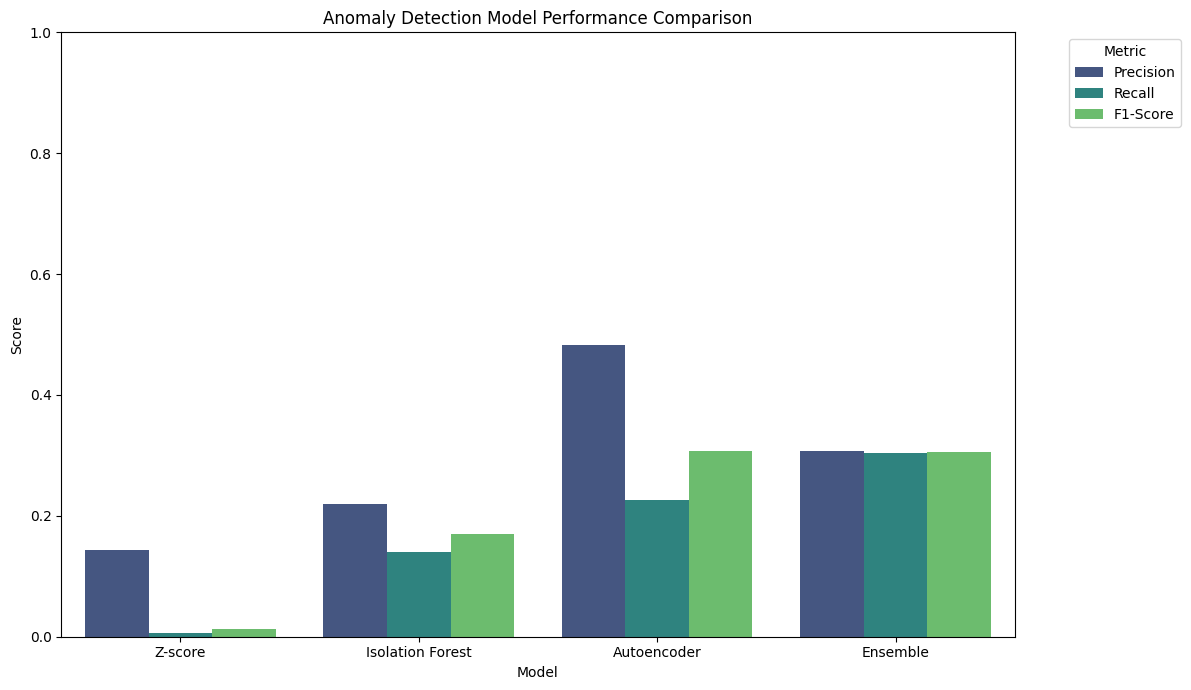

In [28]:
plt.figure(figsize=(12, 7))
sns.barplot(data=model_performance_melted, x='Model', y='Score', hue='Metric', palette='viridis')
plt.ylim(0, 1) # Set y-axis limit between 0 and 1 for performance scores
plt.title('Anomaly Detection Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()